# Task 5: Learning Crowd Dynamics

In [21]:
# All imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
import utils
from sklearn.decomposition import PCA
from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler

%reload_ext autoreload
%autoreload 2

In [4]:
data = np.loadtxt('../../data/MI_timesteps.txt')
data

array([[1.0000e+00, 3.6000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0000e+00, 3.6000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.0000e+00, 4.3000e+01, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.4999e+04, 0.0000e+00, 1.0000e+01, ..., 2.0000e+00, 1.0000e+00,
        4.0000e+01],
       [1.5000e+04, 0.0000e+00, 1.0000e+01, ..., 3.0000e+00, 1.0000e+00,
        4.1000e+01],
       [1.5001e+04, 0.0000e+00, 1.1000e+01, ..., 1.0000e+00, 0.0000e+00,
        4.2000e+01]])

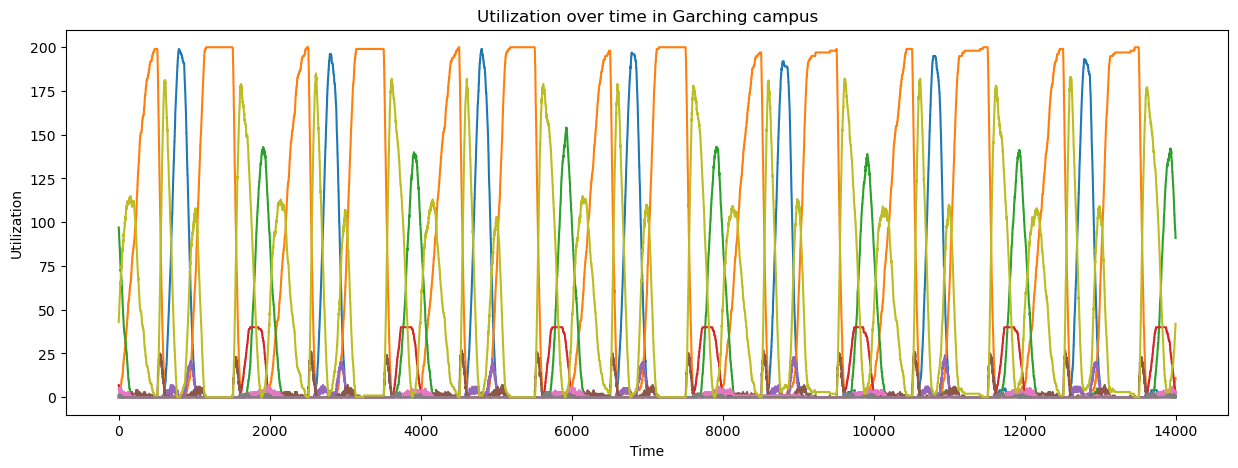

In [105]:
plt.figure(figsize= (15,5))
plt.plot(data[1000:,1:])
plt.xlabel("Time")
plt.ylabel("Utilization")
plt.title("Utilization over time in Garching campus")
plt.savefig('../../plot/utilization_time.png')
#plt.xlim(0,2000)

The state space can be a manifold represented by 9 coordinates (x1, x2, ... x9) each coordinate being a utilization measure of one particular measurement area.
The first column of the dataset being the timesteps.
Since it is most probably a one dimensional periodic manifold (like we saw in task 5), according to Takens theorem we can use 3 dimensions to embed it.

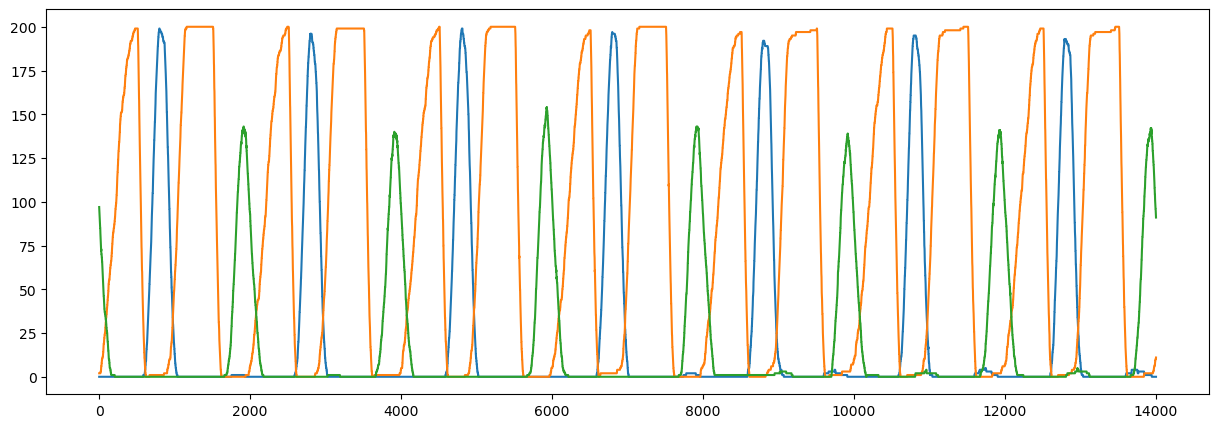

In [18]:
# plot the 3 first columns that will be used to perform PCA
data_1 = data[1000:,1:4]
plt.figure(figsize= (15,5))
plt.plot(data_1)
#plt.xlim(0,2000)

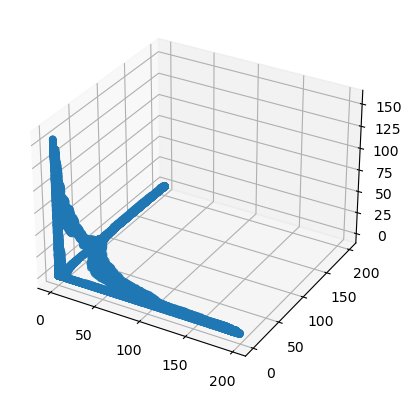

In [19]:
# 3D plot to better visualize: the 3 columns seem to be orthogonal
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(*data_1.T)
plt.show()

The state space can be a manifold represented by 9 coordinates (x1, x2, ... x9) each coordinate being a utilization measure of one particular measurement area.

### TODO: Task 5.1 - Create a delay embedding with 350 delays of the first three measurement areas

In [106]:
# Number of delays
num_delays = 350
num_areas = 3
# Columns per window
# Create delay windows for each row of the dataset
windows = utils.create_windows(data_1, num_delays, num_areas)

In [107]:
# Data standardization
scaler = StandardScaler()
windows_std = scaler.fit_transform(windows)

# Perform PCA
pca = PCA(n_components=3)  # Choose the number of components you want to keep
principal_components = pca.fit_transform(windows_std)
principal_components.shape

(13651, 3)

### TODO: Task 5.2 - Create 9 plots - one for each measurement area

In [108]:
#take original measurement data ignoring 1000 timesteps burn-in period, loading the 9 measurements areas data
x_original = data[1000:,1:]

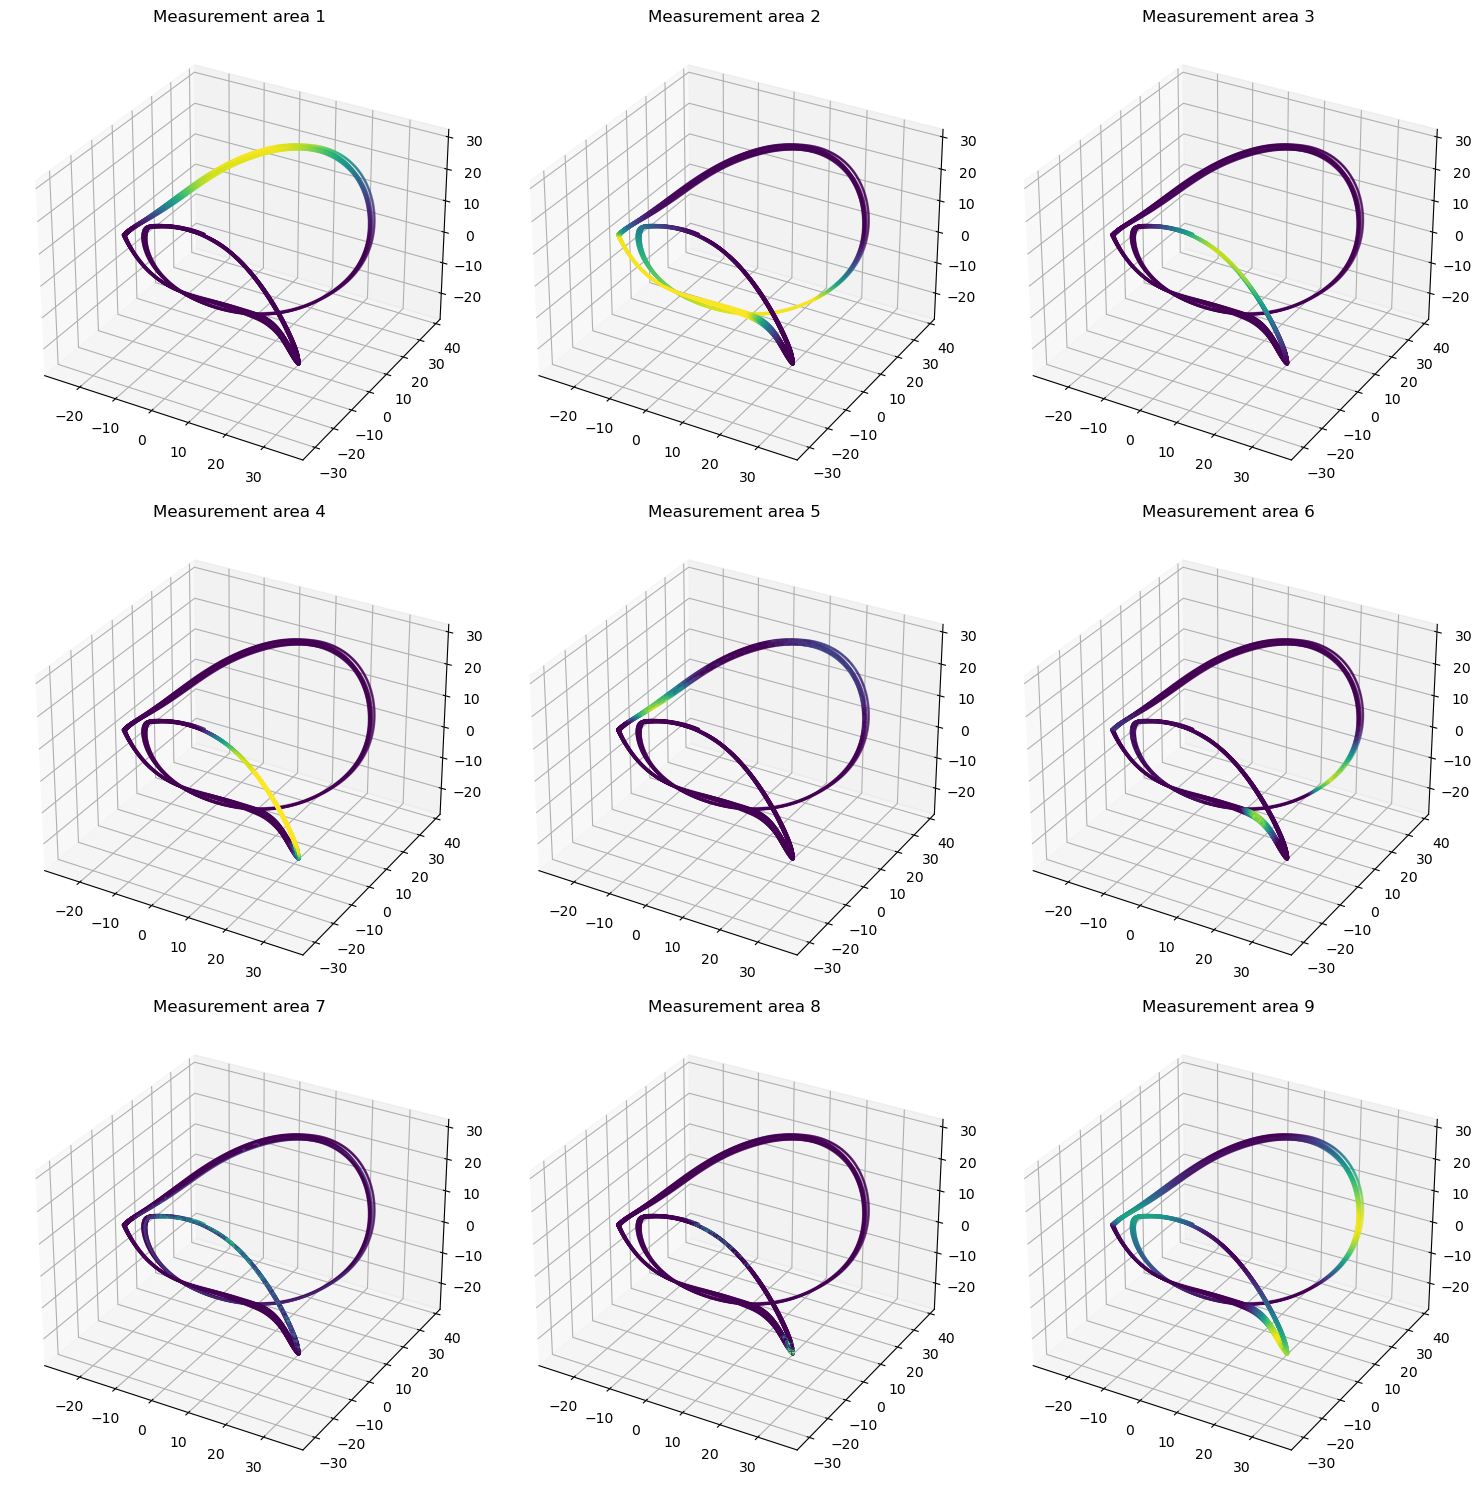

In [110]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})
for i in range(9):
    row = i // 3  # Determine row index (0, 1, 2)
    col = i % 3   # Determine column index (0, 1, 2)
    ax = axs[row,col]
    ax.scatter(*principal_components.T, s=1, c=x_original[:len(principal_components), i])
    ax.set_title('Measurement area ' + str(i+1))
    #plt.show()

plt.tight_layout()
plt.savefig('../../plot/nine_plots.png')
plt.show()

### TODO: Task 5.3 - Learn the dynamics on the periodic curve you embedded in the principal components.

In [111]:
# Compute arclengths
arclengths = np.zeros(len(principal_components))
for i in range(1, len(principal_components)):
    arclengths[i] = arclengths[i-1] + np.linalg.norm(principal_components[i] - principal_components[i-1])

In [112]:
# Compute change of arclength over time
change_of_arclength = np.diff(arclengths)

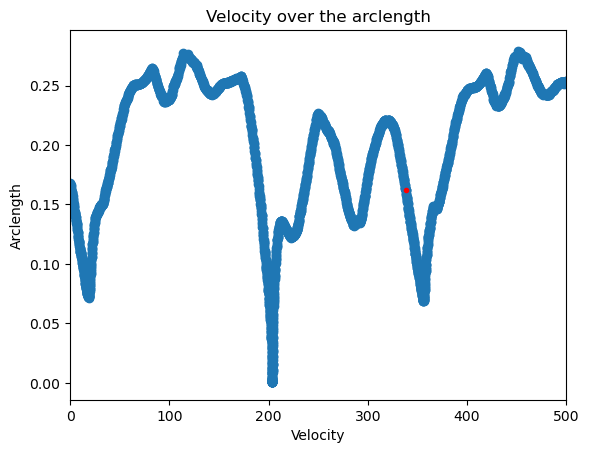

In [114]:
#ground truth
plt.scatter(arclengths[:-1], change_of_arclength)
plt.plot(arclengths[2000], change_of_arclength[2000],marker='.', color='r')
plt.title("Velocity over the arclength")
plt.xlabel('Velocity')
plt.ylabel('Arclength')
plt.xlim(0,500)
plt.savefig('../../plot/velocity_arc.png')

(0.0, 2300.0)

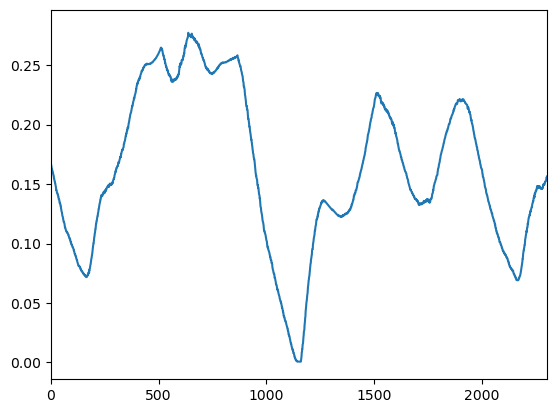

In [37]:
plt.plot(change_of_arclength)
plt.xlim(0,2300)

    We can indentify a period of roughly 2000 timesteps (1 day)

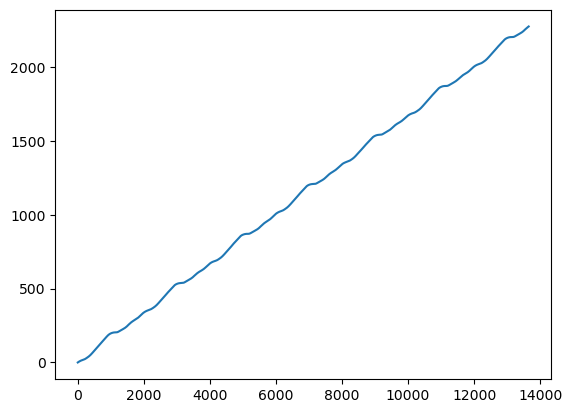

In [115]:
#plt.plot(np.where(arclengths <= 25000)[0],arclengths[:len(np.where(arclengths <= 25000)[0])])
#plt.ylim(0,25000)
plt.plot(arclengths)

In [116]:
#total length of the PCA curved arc
arclengths[-1]

2274.285198363529

In [117]:
arclengths = arclengths.reshape(len(arclengths),1)
time_pca = np.arange(len(change_of_arclength)).reshape(len(change_of_arclength),1)
time_pca.shape
L = 2000
#x = np.linspace(-4.5, 4.5, L)
centers = len(change_of_arclength)*np.random.random_sample((L,1))

In [118]:
#phi = utils.approx_non_linear_field(time_pca,centers, 0.015)
#C =  utils.least_squares(phi., change_of_arclength)
#approx_field_2 = np.dot(phi.T, C)
approx_field_2, C = utils.non_linear_fit_transform(time_pca,change_of_arclength, centers, 0.015)

utils.mean_squared_error(change_of_arclength.reshape(len(change_of_arclength),1), approx_field_2.reshape(len(approx_field_2),1))

9.234205657835924e-05

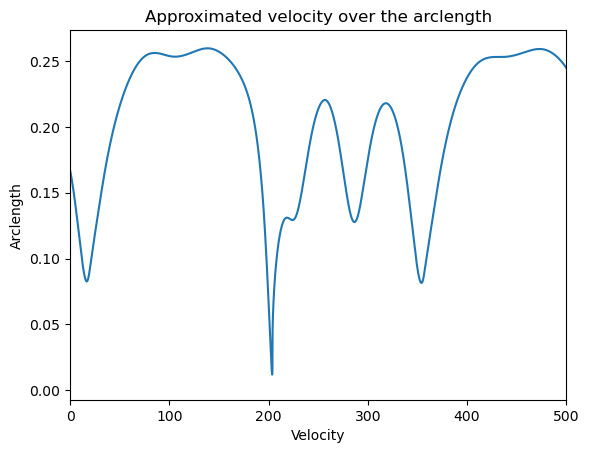

In [121]:
# approximation
plt.plot(arclengths[:-1], approx_field_2)
plt.title("Approximated velocity over the arclength")
plt.xlabel('Velocity')
plt.ylabel('Arclength')
plt.xlim(0,500)
plt.savefig('../../plot/velocity_approx_arc.png')

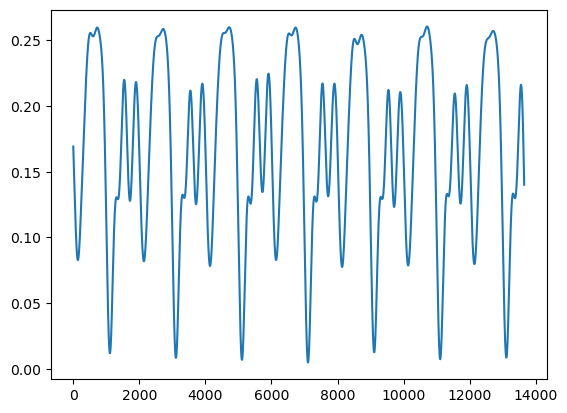

In [69]:
plt.plot(approx_field_2)
#plt.xlim(0,2500)

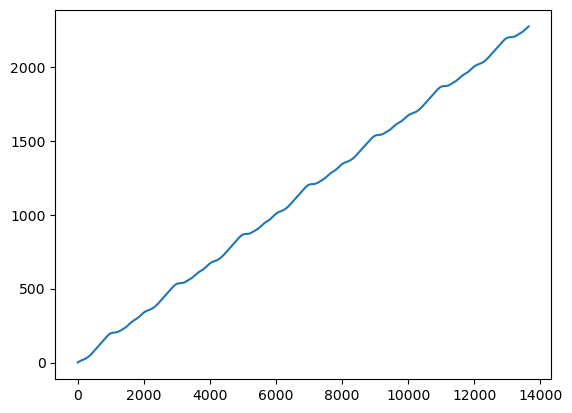

In [54]:
approx_arclengths = np.cumsum(approx_field_2)
plt.plot(approx_arclengths)

In [55]:
approx_arclengths[-1]

2274.272123210915

### TODO: Task 5.4 Prediction of utilization of the MI building 

We need to integrate the arclength vector field over time to get a prediction of the arclength values.

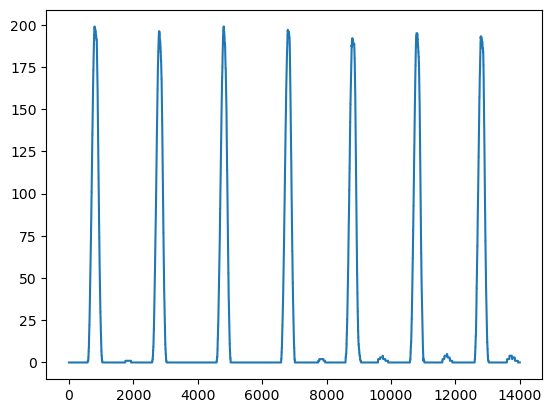

In [60]:
# measurement are number 1, MI building
MI_data = data_1[:,0:1]
plt.plot(MI_data)

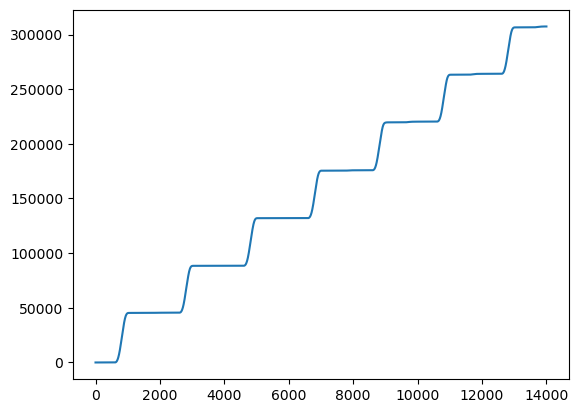

In [57]:
plt.plot(np.cumsum(MI_data))

In [128]:
approx_field_2 = approx_field_2.reshape((len(approx_field_2),1))

In [129]:
predicted_MI_cheat = RBFInterpolator(np.cumsum(approx_field_2).reshape(len(approx_field_2),1), MI_data[0:len(approx_field_2)],
                                kernel='gaussian', epsilon=0.08)(np.cumsum(approx_field_2).reshape(len(approx_field_2),1))

utils.mean_squared_error(predicted_MI_cheat,MI_data[:len(predicted_MI_cheat)])

7.463772505433255e-13

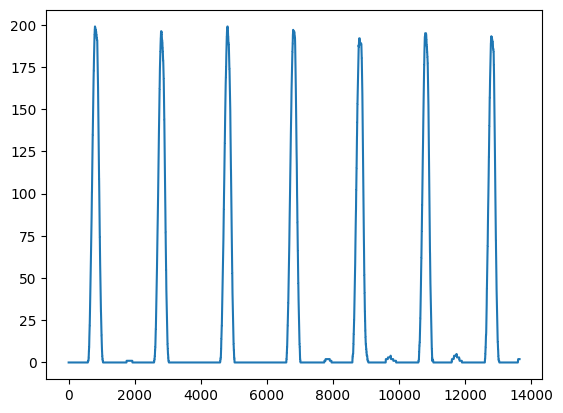

In [131]:
plt.plot(predicted_MI_cheat)

In [93]:
L_2 = 2000
#x = np.linspace(-4.5, 4.5, L)
centers_2 = 3*approx_arclengths[-1]*np.random.random_sample((L_2,1))

In [94]:
approx_arclengths = approx_arclengths.reshape(len(approx_arclengths),1)

In [95]:
# fitting nonlinear approximation
#phi_pred = utils.approx_non_linear_field(approx_arclengths,centers_2, 0.008)
#C_pred =  utils.least_squares(phi_pred.T, MI_data[:len(approx_arclengths)])
#predicted_MI = np.dot(phi_pred.T, C_pred)
fit_MI, C_fit = utils.non_linear_fit_transform(approx_arclengths, MI_data[:len(approx_arclengths)], centers_2, 0.008)

utils.mean_squared_error(MI_data[:len(approx_arclengths)], fit_MI)

0.678481402452218

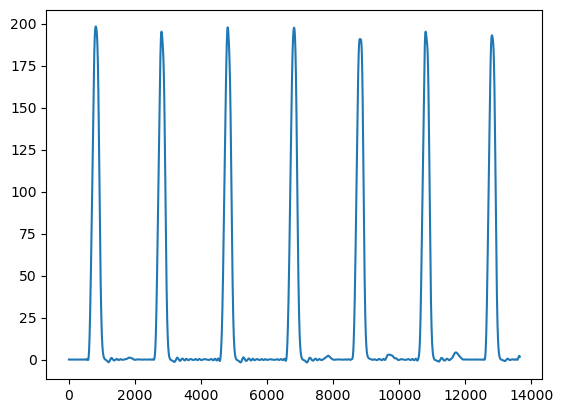

In [96]:
# approximation of MI building utilization during 7 days
plt.plot(fit_MI)

MSE of 0.66, quite good!

First we predict the vector field over the next 14 days.

In [98]:
# prediction next 14 days, knowing 7 days are 14001 timestamps
next_14_days = np.arange(time_pca[-1]+1, time_pca[-1] + 1 + 2*len(data_1))
#L = 2000
#centers_14 = len(next_14_days)*np.random.random_sample((L,1)) + next_14_days[0]
#phi_14 = utils.approx_non_linear_field(next_14_days.reshape(len(next_14_days),1),centers_14, 0.015)
# get arclenght vector field with learned matrix C
#approx_field_14_days" = np.dot(phi_14.T, C)

In [99]:
# vector field for the next 27 days
vector_field_pred = np.concatenate((approx_field_2, approx_field_2, approx_field_2, approx_field_2))

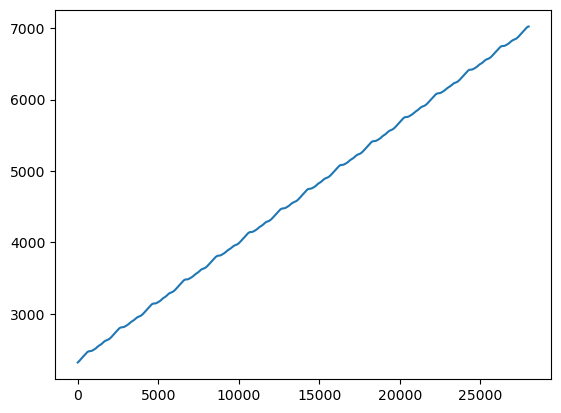

In [100]:
arclengths_pred = np.cumsum(vector_field_pred[:42000])
#plt.plot(next_14_days, np.cumsum(approx_field_14_days))
plt.plot(arclengths_pred[14000:42000])

In [101]:
arclengths_pred

array([1.69255699e-01, 3.37735065e-01, 5.05431581e-01, ...,
       7.02410966e+03, 7.02415822e+03, 7.02420567e+03])

In [102]:
# Actually predicting utilization

#phi_pred_2 = utils.approx_non_linear_field(np.cumsum(approx_field_14_days).reshape(len(approx_field_14_days),1),centers_2, 0.008)
#predicted_MI_2 = np.dot(phi_pred_2.T, C_pred)
arclengths_pred = arclengths_pred[14000:42000]
phi_pred_2 = utils.approx_non_linear_field(arclengths_pred.reshape(len(arclengths_pred),1),centers_2, 0.008)
predicted_MI = utils.transform(phi_pred_2, C_fit)

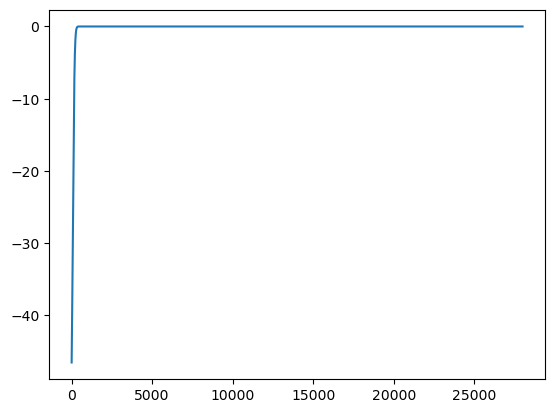

In [103]:
plt.plot(predicted_MI)